# Experiments with logistic regression model for expected goals (xG) prediction.

**Note:**
- Use this file to improve the model, try different features, regularization techniques, etc.
- This file is only for experimentation, do not log to MLflow.
- Implement important changes in the main training script src/tasks/xg/train/train_xg.py.

In [7]:

import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd

print(os.getcwd())

# Add project root to Python path
root = Path(os.getcwd()).parents[3]
sys.path.insert(1, str(root))

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from src.common import io
from src.tasks.xg.features.pipeline import build_feature_pipeline
from src.tasks.xg.train.train_xg import evaluate_model



/Users/cristiandiasdecastro/Documents/dev/football-data-analysis/src/tasks/xg/notebooks


In [8]:
# Load and prepare the data

df = io.read_table(Path(root) / "data/gold/xg_features.parquet")
included_features = [
    "shot_distance",
    "shot_angle",
    "end_x",
    "end_y",
    "body_part_right_foot",
    "body_part_left_foot",
    "body_part_head",
    "body_part_other",
    "is_open_play",
    "one_on_one",
]

pipeline = build_feature_pipeline()
X = pipeline.transform(df)[included_features].dropna()
y = df["is_goal"].dropna()

In [9]:
# Feature engineering. This step happens inside `prepare_features` on the main workflow.

X["log_angle"] = np.log(X["shot_angle"] + 1e-5)
X["one_on_one_x_log_angle"] = X["one_on_one"].astype(int) * X["log_angle"]
X["one_on_one_x_dist"] = X["one_on_one"].astype(int) * X["shot_distance"]
X["head_x_dist"] = X["body_part_head"].astype(int) * X["shot_distance"]
X["distance_x_angle"] = X["shot_distance"] * X["log_angle"]

print(X.columns)

Index(['shot_distance', 'shot_angle', 'end_x', 'end_y', 'body_part_right_foot',
       'body_part_left_foot', 'body_part_head', 'body_part_other',
       'is_open_play', 'one_on_one', 'log_angle', 'one_on_one_x_log_angle',
       'one_on_one_x_dist', 'head_x_dist', 'distance_x_angle'],
      dtype='object')


In [10]:
# feature scaling
scaler = StandardScaler()
X_continous = X[["end_x", "end_y", "shot_distance", "shot_angle", "log_angle", "one_on_one_x_log_angle", "one_on_one_x_dist", "head_x_dist", "distance_x_angle"]]
X_scaled = scaler.fit_transform(X_continous)

X.drop(["end_x", "end_y", "shot_distance", "shot_angle", "log_angle", "one_on_one_x_log_angle", "one_on_one_x_dist", "head_x_dist", "distance_x_angle"], axis=1, inplace=True)
X_scaled_df = pd.DataFrame(X_scaled, columns=["end_x", "end_y", "shot_distance", "shot_angle", "log_angle", "one_on_one_x_log_angle", "one_on_one_x_dist", "head_x_dist", "distance_x_angle"], index=X.index)
X = pd.concat([X, X_scaled_df], axis=1)

In [11]:
# Model training

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = XGBClassifier(random_state=42, eval_metric='logloss', objective="binary:logistic", n_estimators=5000, learning_rate=0.03, tree_method="hist", max_depth=3, min_child_weight=30, colsample_bytree=0.7, subsample=0.7, reg_lambda=10.0)
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_log_loss')
    print(f"Cross-validated Log Loss scores: {-cv_scores}")
    print(f"Mean CV Log Loss: {-cv_scores.mean()}")
    model.fit(X_train, y_train)
     
    return model, X_train, X_test, y_train, y_test

model, X_train, X_test, y_train, y_test = train_model(X, y)

Cross-validated Log Loss scores: [0.13331133 0.1409034  0.14142132 0.14846854 0.14025288]
Mean CV Log Loss: 0.1408714937757239


Test Performance: log_loss=0.140, brier_score=0.044
Train Performance:
  Log Loss: 0.101
  Brier Score: 0.029
  ROC-AUC: 0.987
  Accuracy: 0.959
  Precision: 0.834
  Recall: 0.750
  F1 Score: 0.790

Test Performance:
  Log Loss: 0.140
  Brier Score: 0.044
  ROC-AUC: 0.962
  Accuracy: 0.934
  Precision: 0.667
  Recall: 0.553
  F1 Score: 0.605



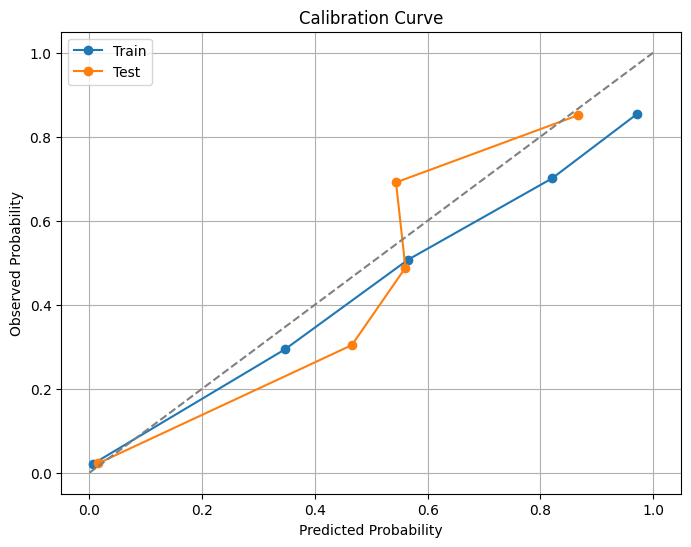

In [12]:
# Evaluate model

metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
for dataset in ["train", "test"]:
    print(f"{dataset.capitalize()} Performance:")
    print(f"  Log Loss: {metrics[dataset]['log_loss']:.3f}")
    print(f"  Brier Score: {metrics[dataset]['brier_score']:.3f}")
    print(f"  ROC-AUC: {metrics[dataset]['roc_auc']:.3f}")
    print(f"  Accuracy: {metrics[dataset]['accuracy']:.3f}")
    print(f"  Precision: {metrics[dataset]['precision']:.3f}")
    print(f"  Recall: {metrics[dataset]['recall']:.3f}")
    print(f"  F1 Score: {metrics[dataset]['f1']:.3f}")
    print()

# Calibration curve
calib_curve_train = metrics["train"]["calibration_curve"]
calib_curve_test = metrics["test"]["calibration_curve"]

plt.figure(figsize=(8, 6))
plt.plot(calib_curve_train[0], calib_curve_train[1], marker='o', label='Train')
plt.plot(calib_curve_test[0], calib_curve_test[1], marker='o', label='Test')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()